## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [2]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')
import scipy
# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [3]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [4]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [5]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_\text{eff}= 5778$K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [6]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

In [7]:
### YOUR ANSWER HERE
temperature = np.linspace(3000,10000, 8)
stellar_magnitude_list = []
for temp in temperature:
    b_magnitude = stellar_magnitude(temp, 'B')
    v_magnitude = stellar_magnitude(temp, 'V')
    B_V_magnitude = b_magnitude - v_magnitude
    stellar_magnitude_list.append(B_V_magnitude)

### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [8]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [ ]:
# Initial guess
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance

### YOUR ANSWER HERE
def model_magnitude(temperature, extinction, distance, selected_filters = None):
    if selected_filters is None:
        selected_filters = list(filter_names)
    observed_magnitude = []
    for i, f in enumerate(selected_filters):
        absolute_magnitude = stellar_magnitude(temperature, f)
        observed_magnitude.append(absolute_magnitude + 5 * np.log10(distance / 10) + extinction * R_lambda[filter_names.index(f)])
    return np.array(observed_magnitude)

def log_likelihood(par, magnitude, error, selected_filters = None):
    if selected_filters is None:
        selected_filters = filter_names
    magnitude = np.array([magnitude[filter_names.index(f)] for f in selected_filters])
    error = np.array([error[filter_names.index(f)] for f in selected_filters])
    model = model_magnitude(par[0], par[1], par[2], selected_filters)
    chi_squared = np.sum(((magnitude - model) / error)**2)
    return -0.5 * chi_squared - np.sum(np.log(error * np.sqrt(2 * np.pi)))

magnitude = np.array([synthetic_star[f]['magnitude'] for f in filter_names])
error = np.array([synthetic_star[f]['error'] for f in filter_names])

#Chi Squared part (minimize negative log-likelihood)
result = minimize(lambda par: -log_likelihood(par, magnitude, error, None), initial_guess)
best_params = result.x
best_model = model_magnitude(best_params[0], best_params[1], best_params[2])
chi_squared_best = np.sum(((magnitude - best_model) / error)**2)
reduced_chi_squared_best = chi_squared_best / max(len(error) - 3, 1)
print(f"The goodness of fit is {reduced_chi_squared_best}")

#Hessian part
Hessian_inverse = result.hess_inv
uncertainty = np.sqrt(np.diag(Hessian_inverse))

Diagonal_inverse = np.diag(1.0 / uncertainty)
Correlation = Diagonal_inverse @ Hessian_inverse @ Diagonal_inverse

print("Correlation matrix: (Diag: temp, av, dist)\n", Correlation)


The goodness of fit is 15834357270.82576
Correlation matrix: (Diag: temp, av, dist)
 [[ 1.00000000e+00  3.43138068e-02  2.63656076e-06]
 [ 3.43138068e-02  1.00000000e+00 -1.11577663e+00]
 [ 2.63656076e-06 -1.11577663e+00  1.00000000e+00]]


### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

In [ ]:
### YOUR ANSWER HERE
random_stars = []
best_param_list = []
reduced_chi_squared_list = []
uncertainty_list = []
np.random.seed(15)
true_model = model_magnitude(TRUE_TEMP, TRUE_A_V, TRUE_DISTANCE)
for i in range(1000):
    random_model = true_model + np.random.normal(0, error)
    random_stars.append(random_model)
    # minimize negative log-likelihood for each Monte Carlo realization
    result = minimize(lambda par: -log_likelihood(par, random_model, error), initial_guess)
    best_params = result.x
    model_best = model_magnitude(best_params[0], best_params[1], best_params[2])
    chi_squared_best = np.sum(((random_model  - model_best) / error)**2)
    reduced_chi_squared_best = chi_squared_best / max(len(error) - 3, 1)
    best_param_list.append(best_params)
    reduced_chi_squared_list.append(reduced_chi_squared_best)

#Gonna plot it to find better parameters
best_param_list = np.array(best_param_list)
best_param_uncertainty = np.std(best_param_list, axis=0)
best_param_list_bias = best_param_list - best_param_uncertainty

### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

In [16]:
### YOUR ANSWER HERE
import emcee
import corner
import matplotlib.pyplot as plt

def LogPrior(par):
    T, A_V, Distance = par
    if (T >= 9000  or T <= 2000) or\
        (A_V <= 0 or A_V >= 2)  or\
        (Distance <= 90 or Distance > 110):   
        return -np.inf
    else:
        return 1/(7000*2*20)
    
def LogPosterior(params, model, error, selected_filters = None):
    lnprior = LogPrior(params)
    if not np.isfinite(lnprior):
        return -np.inf
    lnlike = log_likelihood(params, model, error, selected_filters)
    return lnprior + lnlike
ndim = 3
nwalkers =  100
p0 = np.array(initial_guess) + np.random.randn(nwalkers, ndim)*np.array([100.0, 0.05, 2.0])
First_Case = filter_names
rijhk_filters = [f for f in filter_names if f in ['R','I','J','H','K']]
bvrij_filters = [f for f in filter_names if f in ['B','V','R','I','J']]
sampler1 = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, kwargs={'model':magnitude, 'error':error, 'selected_filters':rijhk_filters})
state1 = sampler1.run_mcmc(p0, 2000, progress=True)
sampler1.reset()
sampler1.run_mcmc(state1, 10000, progress=True)
chain1 = sampler1.get_chain(flat=True)

#Second_Case = ['R','I','J','H','K']
#sampler2 = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, kwargs={'model':magnitude, 'error':error, 'selected_filters':Second_Case})
#state2 = sampler2.run_mcmc(p0, 10000, progress=True)
#sampler2.reset()
#sampler2.run_mcmc(state2, 10000, progress=True)
#chain2 = sampler2.get_chain(flat=True)

#Third_Case = ['B', 'V', 'R','I','J']
#sampler3 = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, kwargs={'model':magnitude, 'error':error, 'selected_filters':Third_Case})
#state3 = sampler3.run_mcmc(p0, 10000, progress=True)
#sampler3.reset()
#sampler3.run_mcmc(state3, 10000, progress=True)
#chain3 = sampler3.get_chain(flat=True)


Text(0.5, 0.98, 'All filters')

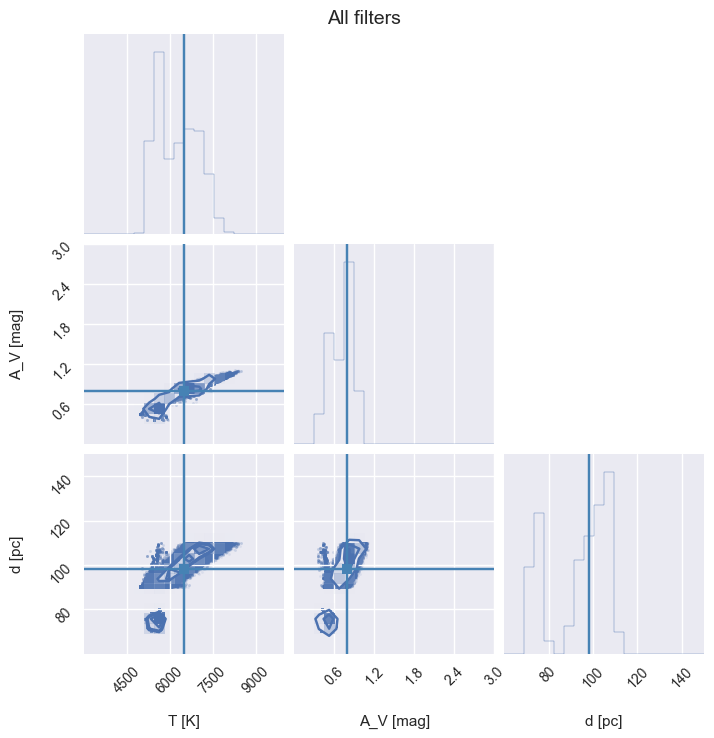

In [17]:
labels = [r"T [K]", r"A_V [mag]", r"d [pc]"]
ranges = [(3000, 10000), (0, 3), (60, 150)]

fig_all = corner.corner(chain1, labels=labels, truths=[6500,0.8,98], range=ranges, color='C0')
fig_all.suptitle("All filters", fontsize=14)
